In [1]:
from google.colab import files #using this to choose a csv file from my local directory
uploaded = files.upload() #running both of these lines will open the below prompt to execute above code

Saving genres_v2.csv to genres_v2.csv


Importing required packages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype
import sklearn
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

First few entries of the dataset

In [3]:
sptfy_df = pd.read_csv("genres_v2.csv")
sptfy_df.head()
sptfy_df['duration_minute'] = round((sptfy_df['duration_ms']/(1000*60) % 60),4)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Storing the total number of rows in the dataset

In [4]:
shape = sptfy_df.shape
tots = shape[0]

genre = sptfy_df['genre']

In [66]:
tots

42305

Exploring

In [5]:
print(sptfy_df.columns)

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'song_name', 'Unnamed: 0', 'title',
       'duration_minute'],
      dtype='object')


Identifying the strings in the dataset for one hot encoding and/or for dataset splitting

In [6]:
dofdf = sptfy_df.info()
print(dofdf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  type              42305 non-null  object 
 12  id                42305 non-null  object 
 13  uri               42305 non-null  object 
 14  track_href        42305 non-null  object 
 15  analysis_url      42305 non-null  object 
 16  duration_ms       42305 non-null  int64 

To check for missing values if any

In [7]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("This Spotify Dataset has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")

        return mz_table

missing_zero_values_table(sptfy_df)

This Spotify Dataset has 23 columns and 42305 Rows.
There are 3 columns that have missing values.


Zero Values  Missing Values  % of Total Values  \
Unnamed: 0            1           21525               50.9   
title                 0           21525               50.9   
song_name             0           20786               49.1   

            Total Zero Missing Values  % Total Zero Missing Values Data Type  
Unnamed: 0                      21526                         50.9   float64  
title                           21525                         50.9    object  
song_name                       20786                         49.1    object

Removing unnamed and type column as unnamed contains nothing and type contains only 1 unique value "audio_feature"

In [8]:
nsptfy_df = sptfy_df.drop(['Unnamed: 0','type'], 1)
nsptfy_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence  ...                      id  \
0          0.013400    0.0556   0.3890  ...  2Vc6NJ9PW9gD9q343XFRKx   
1          0.000000    0.1180   0.1240  ...  7pgJBLVz5VmnL7uGHmRj6p   
2          0.000004    0.3720   0.0391  ...  0vSWgAlfpye0WCGeNmuNhy   
3          0.000000    0.1140   0.1750  ...  0VSXnJqQkwuH2ei1nOQ1nu   
4          0.000000    0.1660   0.5910  ...  4jCeguq9rMTlbMmPHuO7S3   

                                    uri  \
0  spotify:track:2Vc6NJ9PW9gD9q343XFRKx   
1  spotify:track:7pgJBLVz5VmnL7uGHmRj6p   
2  spotify:track:0vSWgAlfpye0WCGeNmuNhy   
3  spotify:track:0VSXnJqQkwuH2ei1nOQ1nu   
4  spotify:track:4jCeguq9rMTlbMmPHuO7S3   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...   
1  https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...   
2  https://api.spotify.com/v1/tracks/0vSWgAlfpye0...   
3  https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...   
4  https://api.spotify.com/v1/tracks/4jCeguq9rMTl...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2Vc6...      124539   
1  https://api.spotify.com/v1/audio-analysis/7pgJ...      224427   
2  https://api.spotify.com/v1/audio-analysis/0vSW...       98821   
3  https://api.spotify.com/v1/audio-analysis/0VSX...      123661   
4  https://api.spotify.com/v1/audio-analysis/4jCe...      123298   

   time_signature      genre                                      song_name  \
0               4  Dark Trap                            Mercury: Retrograde   
1               4  Dark Trap                                      Pathology   
2               4  Dark Trap                                       Symbiote   
3               3  Dark Trap  ProductOfDrugs (Prod. The Virus and Antidote)   
4               4  Dark Trap                                          Venom   

  title duration_minute  
0   NaN          2.0756  
1   NaN          3.7404  
2   NaN          1.6470  
3   NaN          2.0610  
4   NaN          2.0550  

[5 rows x 21 columns]

Identifying the columns with string datatype entries


In [9]:
obj_cols = list(nsptfy_df.select_dtypes(include = 'object'))
print(obj_cols)

['id', 'uri', 'track_href', 'analysis_url', 'genre', 'song_name', 'title']


Making a new dataset of only string data columns

In [10]:
obj_sptfy = nsptfy_df[obj_cols]
obj_sptfy.head()

id                                   uri  \
0  2Vc6NJ9PW9gD9q343XFRKx  spotify:track:2Vc6NJ9PW9gD9q343XFRKx   
1  7pgJBLVz5VmnL7uGHmRj6p  spotify:track:7pgJBLVz5VmnL7uGHmRj6p   
2  0vSWgAlfpye0WCGeNmuNhy  spotify:track:0vSWgAlfpye0WCGeNmuNhy   
3  0VSXnJqQkwuH2ei1nOQ1nu  spotify:track:0VSXnJqQkwuH2ei1nOQ1nu   
4  4jCeguq9rMTlbMmPHuO7S3  spotify:track:4jCeguq9rMTlbMmPHuO7S3   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...   
1  https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...   
2  https://api.spotify.com/v1/tracks/0vSWgAlfpye0...   
3  https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...   
4  https://api.spotify.com/v1/tracks/4jCeguq9rMTl...   

                                        analysis_url      genre  \
0  https://api.spotify.com/v1/audio-analysis/2Vc6...  Dark Trap   
1  https://api.spotify.com/v1/audio-analysis/7pgJ...  Dark Trap   
2  https://api.spotify.com/v1/audio-analysis/0vSW...  Dark Trap   
3  https://api.spotify.com/v1/audio-analysis/0VSX...  Dark Trap   
4  https://api.spotify.com/v1/audio-analysis/4jCe...  Dark Trap   

                                       song_name title  
0                            Mercury: Retrograde   NaN  
1                                      Pathology   NaN  
2                                       Symbiote   NaN  
3  ProductOfDrugs (Prod. The Virus and Antidote)   NaN  
4                                          Venom   NaN

Creating a dataset of columns only with numeric(float or int) values

In [11]:
newnum_sptfy =  nsptfy_df.drop(columns = obj_cols)
newnum_sptfy.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.013400    0.0556   0.3890  156.985       124539               4   
1          0.000000    0.1180   0.1240  115.080       224427               4   
2          0.000004    0.3720   0.0391  218.050        98821               4   
3          0.000000    0.1140   0.1750  186.948       123661               3   
4          0.000000    0.1660   0.5910  147.988       123298               4   

   duration_minute  
0           2.0756  
1           3.7404  
2           1.6470  
3           2.0610  
4           2.0550

Converting the duration in millisecond to minutes

In [12]:
newnum_sptfy['duration_minute'] = round((newnum_sptfy['duration_ms']/(1000*60) % 60),4)
newnum2_sptfy = newnum_sptfy.drop(columns = ['duration_ms','time_signature'])
newnum2_sptfy.head()


danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_minute  
0          0.013400    0.0556   0.3890  156.985           2.0756  
1          0.000000    0.1180   0.1240  115.080           3.7404  
2          0.000004    0.3720   0.0391  218.050           1.6470  
3          0.000000    0.1140   0.1750  186.948           2.0610  
4          0.000000    0.1660   0.5910  147.988           2.0550

Correlations between music metrics

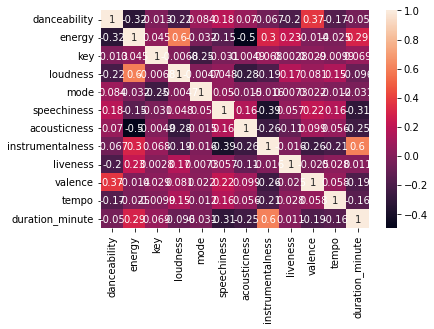

In [13]:
corrMatrix = newnum2_sptfy.corr()
sns.heatmap(corrMatrix, annot = True)
plt.show()

Pairs:


1.   Energy vs danceability
2.   loudness danceability
3.   acousticness vs energy
4.   instrumentalness vs speechiness
5.   duration_minute vs speechiness

Amongst Others!



Exploring the genres in the dataset

In [14]:
genre_count = nsptfy_df['genre'].value_counts().to_frame()
genre_count
#enre_count.columns = ['Genre','Total Count']

genre
Underground Rap   5875
Dark Trap         4578
Hiphop            3028
trance            2999
trap              2987
techhouse         2975
dnb               2966
psytrance         2961
techno            2956
hardstyle         2936
RnB               2099
Trap Metal        1956
Rap               1848
Emo               1680
Pop                461

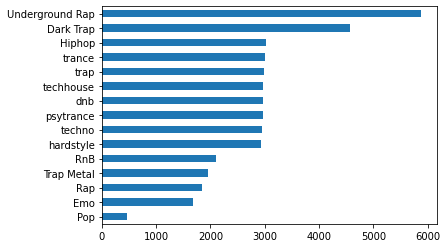

In [15]:
nsptfy_df['genre'].value_counts().sort_values().plot(kind = 'barh')

More on the numerical part of the dataset

In [16]:
import plotly.express as px
newnum2_sptfy.head()
duration_min = newnum2_sptfy['duration_minute']
newnum2_spftfy = newnum2_sptfy.drop("duration_minute", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


Standardizing the data

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler
sptfystd = pd.DataFrame(scaler.fit_transform(newnum2_spftfy), columns = newnum2_spftfy.columns)
sptfystd.head()
sptfystd.insert(loc = 1, column = 'Time in Minutes', value = duration_min)
sptfystd.head()


danceability  Time in Minutes    energy       key  loudness      mode  \
0      1.223608           2.0756  0.280079 -0.919298 -0.305514  0.905517   
1      0.508480           3.7404 -1.466185  0.717318 -0.259954  0.905517   
2      1.344924           1.6470  0.709845 -0.100990  0.572039  0.905517   
3     -1.043093           2.0610  0.100557 -1.464837  0.596860  0.905517   
4      1.012900           2.0550 -0.753535 -0.919298 -0.408876  0.905517   

   speechiness  acousticness  instrumentalness  liveness   valence     tempo  
0     2.246552     -0.212853         -0.727231 -0.902637  0.136790  0.398876  
1    -0.453057      1.784518         -0.763370 -0.547231 -0.999586 -1.358564  
2    -0.588592     -0.482135         -0.763359  0.899456 -1.363655  2.959861  
3    -0.266002     -0.424181         -0.763370 -0.570013 -0.780887  1.655485  
4     1.239945      0.707390         -0.763370 -0.273841  1.003008  0.021554

Energy vs Danceability vs Liveness vs Time in Minutes (in standardised data)

In [18]:
fig1 = px.scatter(sptfystd, x="energy", y="danceability", color="liveness", size = 'Time in Minutes')
fig1.update_layout(title="..")
fig1.show()

Energy vs Danceability vs Liveness vs Time in Minutes (in unstandardised data)

In [19]:
fig1 = px.scatter(newnum2_sptfy, x="energy", y="danceability", color="liveness", size = 'duration_minute')
fig1.update_layout(title="..")
fig1.show()

5 features user input function:



In [20]:
print(newnum2_sptfy.columns)

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_minute'],
      dtype='object')


In [21]:
def random_features(df, a, b, c, d, e):
  fig = px.scatter_3d(df, x = a, y = b, z = c, color = d, size = e)
  fig.update_layout(title = a.capitalize() + " vs " + b.capitalize() + " vs " + c.capitalize() + " vs " + d.capitalize() + " vs " + e.capitalize())
  fig.show()

random_features(newnum2_sptfy, "energy", "tempo", "loudness", "danceability", "duration_minute")


Clustering 

In [22]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import numpy as np
inertia = []
for col in range(1,11):
  kmeans = KMeans(n_clusters = col, init = "k-means++",n_init = 10, tol=1e-04, random_state = 42)
  kmeans.fit(newnum2_sptfy)
  inertia.append(kmeans.inertia_)
fig = go.Figure(data = go.Scatter(x = np.arange(1,11), y = inertia))
fig.update_layout(title = "Inertia vs Clusters", xaxis = dict(range = [0,11], title = "Cluster Number"), yaxis = {'title':'Inertia'},
                  annotations = [
                                 dict(
                                     x = 3, y = inertia[2], xref = "x", text = "Elbow",showarrow= True, arrowhead = 7, ax = 20, ay = -40)])

To speed up algorithms. Doing a Principal Component Analysis

In [23]:
lis_feat = newnum2_sptfy.columns

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(sptfystd)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf

principal component 1  principal component 2
0                  -2.676612               0.064498
1                  -0.990717               1.928879
2                  -2.174223              -1.787776
3                  -1.906180              -1.547250
4                  -2.958699               0.790868
...                      ...                    ...
42300               0.113506              -0.261305
42301              -0.563421              -0.389096
42302               0.141464              -2.047201
42303               1.220446              -0.888434
42304              -0.747032              -1.822800

[42305 rows x 2 columns]

In [25]:
finalpca = pd.concat([principalDf,sptfy_df[['genre']]], axis = 1)
finalpca

principal component 1  principal component 2      genre
0                  -2.676612               0.064498  Dark Trap
1                  -0.990717               1.928879  Dark Trap
2                  -2.174223              -1.787776  Dark Trap
3                  -1.906180              -1.547250  Dark Trap
4                  -2.958699               0.790868  Dark Trap
...                      ...                    ...        ...
42300               0.113506              -0.261305  hardstyle
42301              -0.563421              -0.389096  hardstyle
42302               0.141464              -2.047201  hardstyle
42303               1.220446              -0.888434  hardstyle
42304              -0.747032              -1.822800  hardstyle

[42305 rows x 3 columns]

Two Component Analysis


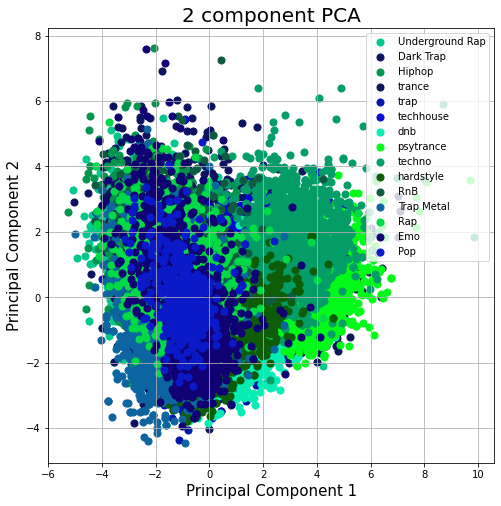

In [26]:
from random import randint
color = []
n = 15
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Underground Rap', 'Dark Trap', 'Hiphop', 'trance', 'trap', 'techhouse', 'dnb', 'psytrance', 'techno', 
           'hardstyle', 'RnB', 'Trap Metal', 'Rap', 'Emo', 'Pop']
for i in range(n):
  color.append('#%06X' % randint(0, 0xFFFFF))
for target, color in zip(targets,color):
    indicesToKeep = finalpca['genre'] == target
    ax.scatter(finalpca.loc[indicesToKeep, 'principal component 1']
               , finalpca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

The variance is maximized along PC1 which explains 28.52% of the variance and PC2 explains 14.85% of the variance. Together, they explain 43.37% of the variance in the data.

In [27]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.28520953 0.14849761]


Adding genre to the dataset and converting it to dummy variables

In [28]:
sptfynum2 = pd.concat([newnum2_sptfy,sptfy_df[['genre']]], axis = 1)
sptfynum2.head()
#sptfyndum = pd.get_dummies(sptfynum2, prefix=None, prefix_sep = "_", dummy_na=False, columns=None)
#sptfyndum.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_minute      genre  
0          0.013400    0.0556   0.3890  156.985           2.0756  Dark Trap  
1          0.000000    0.1180   0.1240  115.080           3.7404  Dark Trap  
2          0.000004    0.3720   0.0391  218.050           1.6470  Dark Trap  
3          0.000000    0.1140   0.1750  186.948           2.0610  Dark Trap  
4          0.000000    0.1660   0.5910  147.988           2.0550  Dark Trap

In [29]:
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(sptfystd)
sptfystd['Cluster'] = y
sptfystd.head()

danceability  Time in Minutes    energy       key  loudness      mode  \
0      1.223608           2.0756  0.280079 -0.919298 -0.305514  0.905517   
1      0.508480           3.7404 -1.466185  0.717318 -0.259954  0.905517   
2      1.344924           1.6470  0.709845 -0.100990  0.572039  0.905517   
3     -1.043093           2.0610  0.100557 -1.464837  0.596860  0.905517   
4      1.012900           2.0550 -0.753535 -0.919298 -0.408876  0.905517   

   speechiness  acousticness  instrumentalness  liveness   valence     tempo  \
0     2.246552     -0.212853         -0.727231 -0.902637  0.136790  0.398876   
1    -0.453057      1.784518         -0.763370 -0.547231 -0.999586 -1.358564   
2    -0.588592     -0.482135         -0.763359  0.899456 -1.363655  2.959861   
3    -0.266002     -0.424181         -0.763370 -0.570013 -0.780887  1.655485   
4     1.239945      0.707390         -0.763370 -0.273841  1.003008  0.021554   

   Cluster  
0        3  
1        2  
2        3  
3        0  
4        3

In [30]:
sptfy_df['Cluster'] = y

In [31]:
fig = px.scatter(sptfy_df, x = 'liveness', color = 'Cluster')
fig.show()

In [32]:
clust1 = sptfy_df['Cluster']==1
clust1df = sptfy_df[clust1]
clust1df.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
241          0.745   0.617    6    -7.220     0       0.1440       0.16800   
1417         0.626   0.603    5    -9.047     0       0.2070       0.04500   
2487         0.491   0.702    0    -6.909     1       0.1090       0.30200   
2502         0.580   0.617   11   -11.260     1       0.0349       0.11500   
2512         0.687   0.574   11    -8.697     0       0.0290       0.00801   

      instrumentalness  liveness  valence  ...  \
241           0.000000    0.3890    0.185  ...   
1417          0.000228    0.1330    0.138  ...   
2487          0.841000    0.0579    0.334  ...   
2502          0.885000    0.1170    0.173  ...   
2512          0.768000    0.1410    0.143  ...   

                                             track_href  \
241   https://api.spotify.com/v1/tracks/0joQFwiBKmi6...   
1417  https://api.spotify.com/v1/tracks/6qqVvmMtIeEK...   
2487  https://api.spotify.com/v1/tracks/2FhGitc3KC7g...   
2502  https://api.spotify.com/v1/tracks/7nhBJvKNRqNt...   
2512  https://api.spotify.com/v1/tracks/57VM8YqkSLUb...   

                                           analysis_url duration_ms  \
241   https://api.spotify.com/v1/audio-analysis/0joQ...      346907   
1417  https://api.spotify.com/v1/audio-analysis/6qqV...      474157   
2487  https://api.spotify.com/v1/audio-analysis/2FhG...      308152   
2502  https://api.spotify.com/v1/audio-analysis/7nhB...      285000   
2512  https://api.spotify.com/v1/audio-analysis/57VM...      289000   

     time_signature      genre  \
241               4  Dark Trap   
1417              4  Dark Trap   
2487              4  Dark Trap   
2502              4  Dark Trap   
2512              4  Dark Trap   

                                             song_name  Unnamed: 0  title  \
241                                      Codeine Crazy         NaN    NaN   
1417  I No Longer Fear The Razor Guarding My Heel (IV)         NaN    NaN   
2487                                            Try Me         NaN    NaN   
2502                                    Dreamscape '95         NaN    NaN   
2512                                            Cement         NaN    NaN   

     duration_minute Cluster  
241           5.7818       1  
1417          7.9026       1  
2487          5.1359       1  
2502          4.7500       1  
2512          4.8167       1  

[5 rows x 24 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7063371f10>,
      dtype=object)

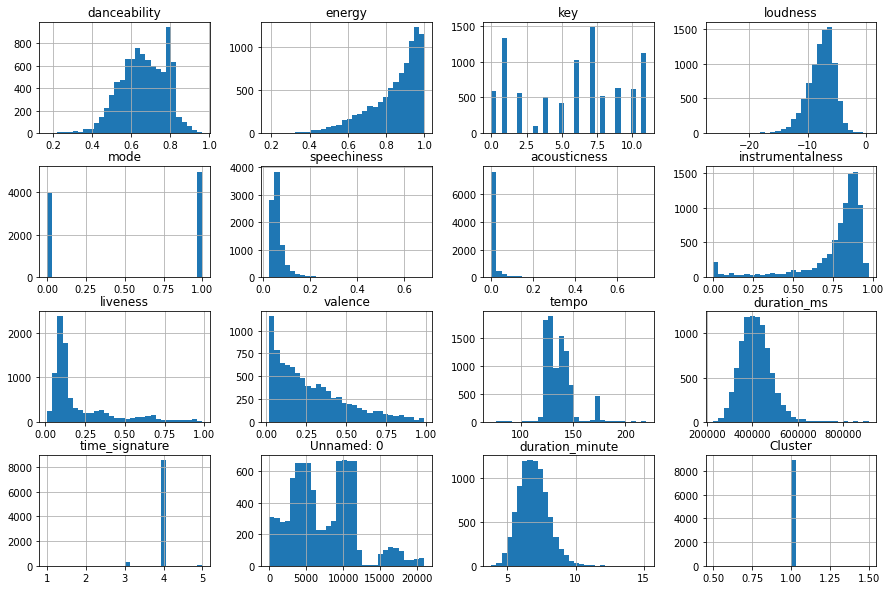

In [33]:
clust1df.hist(bins=30, figsize = (15,10))

**Cluster 1**:

> 


This cluster has a higher danceability, energy, loudness but a low tempo. Progressing on further to explain each notable feature in depth.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f705d7a0c50>]],
      dtype=object)

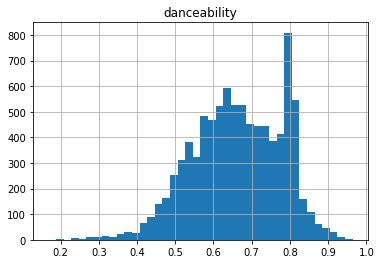

In [34]:
clust1df.hist(column = 'danceability',bins = 40)

The danceability distribution is left skewed. Most songs in this cluster has an above average danceability. This means these songs have a good combination of musical elements including rhythm stability, beat strength, overall regularity and tempo.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f705d70db10>]],
      dtype=object)

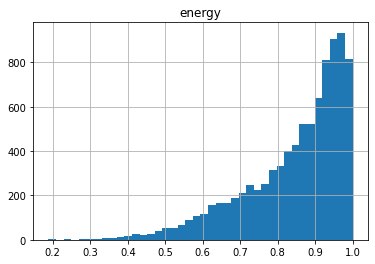

In [35]:
clust1df.hist(column = 'energy',bins = 40)

Almost a normal distribution



In [36]:
clust1df['energy'].describe()

count    8900.000000
mean        0.844763
std         0.133544
min         0.188000
25%         0.772000
50%         0.885000
75%         0.949000
max         1.000000
Name: energy, dtype: float64

These songs have an average energy of 0.47, probably average sound levels and active.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f705d609910>]],
      dtype=object)

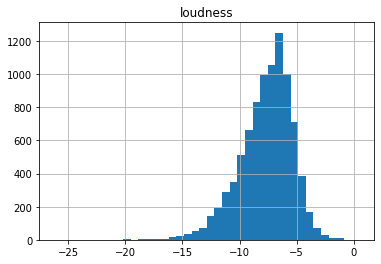

In [37]:
clust1df.hist(column = 'loudness',bins = 40)

Most of the songs were recorded in between -15dB and -6dB. Most of the song includes many loud parts and very lower number of lows. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f705d508810>]],
      dtype=object)

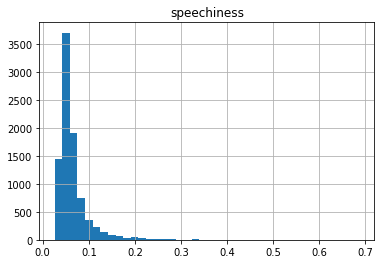

In [38]:
clust1df.hist(column = 'speechiness',bins = 40)

Right skewed graph of speechiness with majority of songs having lower number of spoken words and few outliers with a lot of words.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f705d4a9e10>]],
      dtype=object)

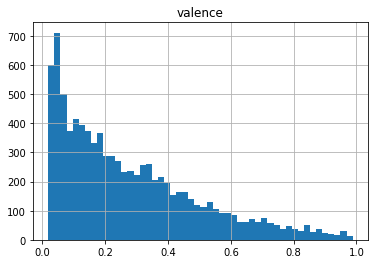

In [39]:
clust1df.hist(column = 'valence',bins = 50)

The valence of these songs are have a right skew. High valence sound more positive which would show emotions of happy, euphoric or cheerul, whereas those with low valence are negative such as sad, depressed and angry. A mean around 0.3 - 0.5 means that these songs are near the threshold of happy songs.

In [40]:
clust1df['valence'].describe()

count    8900.000000
mean        0.276811
std         0.218834
min         0.018700
25%         0.098075
50%         0.219000
75%         0.399000
max         0.988000
Name: valence, dtype: float64

Almost 80% of these songs have a lower valence i.e. lower than the threshold of 0.5 for happy songs. This could mean that 

Summary of Cluster 1 and looking and at the songs.

After playing a few songs from the random genre types in the dataset, I wanted to know if there's a way to understand if the gender of the artist is dependent on other variables. Below I have made a function to manually factor variables 1: Male 0: Female and 2: Both. This function would be called later and along with another personal rating column which is rated out of 10
.

Creating a function for choosing specific clusters and genres.

In [154]:
#b = cluster number you want to explore
#genres = genre you want to explore
def cluster_analysis(df,b,genres):
  clust = df['Cluster']==b
  clustdf = df[clust]
  hhc1 = clustdf[clustdf['genre']==genres]
  newc2 = hhc1.sort_values(by=['danceability'], ascending = False)
  global df_name
  df_name = newc2[['uri','song_name','duration_minute','energy','danceability']]
  return clustdf.hist(column = ['loudness','energy','danceability','valence','loudness','speechiness'],bins = 40, figsize = (10,10)), df_name.shape

#function for gender of the artist
def gender_entry(df_name):
  for (coln, colv) in df_name.iteritems():
    if coln == "song_name":
      a = colv.values

  count = 0
  Artist = []
  for i in a:
    gen = int(input("Enter the gender for " +i+" song "))
    Artist.append(gen)
    count += 1
    if count == len(a):
      break
  df_name['Gender of Artist'] = Artist
  return df_name

#function for rating of the song
def Rating(df_name):
  for (coln, colv) in df_name.iteritems():
    if coln == "song_name":
      a = colv.values

  count2 = 0
  rate = []
  for i in a:
    gen = int(input("Enter the gender for " +i+" song "))
    rate.append(gen)
    count2 += 1
    if count2 == len(a):
      break
  df_name['Random Rating'] = rate
  return df_name

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7053753110>,
       dtype=object), (51, 5))

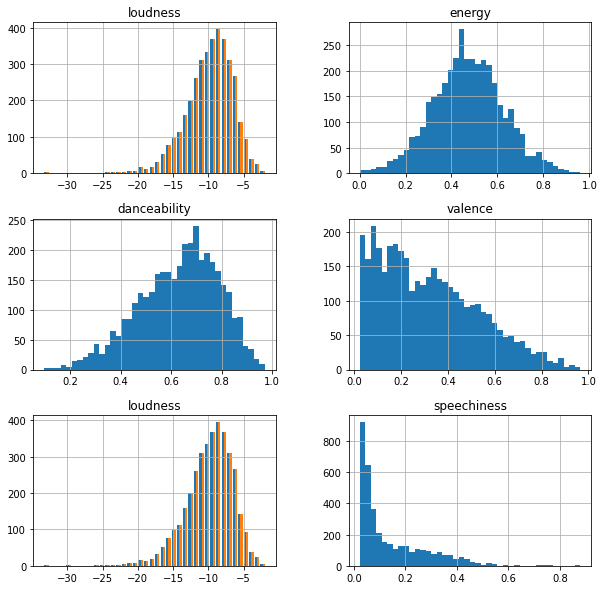

In [155]:
cluster_analysis(sptfy_df,2,"Pop")

In [156]:
gender_entry(df_name)

Enter the gender for Somebody That I Used To Know song 2
Enter the gender for Girls Like You (feat. Cardi B) song 2
Enter the gender for Girls Like You (feat. Cardi B) song 2
Enter the gender for Dance Monkey song 0
Enter the gender for We Should Tell the Truth song 1
Enter the gender for Where Is the Love (Wave Remix) song 0
Enter the gender for Thinking out Loud song 1
Enter the gender for Thinking out Loud song 1
Enter the gender for Memories song 1
Enter the gender for Sunflower - Spider-Man: Into the Spider-Verse song 1
Enter the gender for We Don't Talk Anymore (feat. Selena Gomez) song 2
Enter the gender for death bed (coffee for your head) song 2
Enter the gender for 7 rings song 0
Enter the gender for What You Know Bout Love song 1
Enter the gender for bad guy song 0
Enter the gender for Smoke & Ash song 0
Enter the gender for See You Again (feat. Charlie Puth) song 1
Enter the gender for See You Again (feat. Charlie Puth) song 1
Enter the gender for Issues song 0
Enter the ge

uri  \
18189  spotify:track:1qDrWA6lyx8cLECdZE7TV7   
18465  spotify:track:6FRLCMO5TUHTexlWo8ym1W   
18167  spotify:track:7fa9MBXhVfQ8P8Df9OEbD8   
18407  spotify:track:1rgnBhdG2JDFTbYkYRZAku   
18242  spotify:track:3SR72eMiFDPIxMJc4587yN   
18197  spotify:track:5maiCdBRKITzSbx4mdyy8r   
18494  spotify:track:1Slwb6dOYkBlWal1PGtnNg   
18152  spotify:track:34gCuhDGsG4bRPIf9bb02f   
18416  spotify:track:2b8fOow8UzyDFAE27YhOZM   
18468  spotify:track:1A6OTy97kk0mMdm78rHsm8   
18374  spotify:track:06KyNuuMOX1ROXRhj787tj   
18439  spotify:track:7eJMfftS33KTjuF7lTsMCx   
18462  spotify:track:14msK75pk3pA33pzPVNtBF   
18402  spotify:track:1tkg4EHVoqnhR6iFEXb60y   
18453  spotify:track:2Fxmhks0bxGSBdJ92vM42m   
18045  spotify:track:7jUBj3nZfs0dRqr68b4yxy   
18226  spotify:track:7wqSzGeodspE3V6RBD5W8L   
18198  spotify:track:2JzZzZUQj3Qff7wapcbKjc   
18367  spotify:track:1sXUWdKx03aP9Gmzft58rt   
18165  spotify:track:2BOqDYLOJBiMOXShCV1neZ   
18206  spotify:track:7wch5iJo4JFtmrRfPVUBr1   
18112  spotify:track:0vg4WnUWvze6pBOJDTq99k   
18096  spotify:track:34nzen9vQclFJN8ypTfWk4   
18455  spotify:track:45bE4HXI0AwGZXfZtMp8JR   
18405  spotify:track:4y4spB9m0Q6026KfkAvy9Q   
18200  spotify:track:2YlZnw2ikdb837oKMKjBkW   
18087  spotify:track:5g7PPvRTn6OVSb6iMKXoN7   
18495  spotify:track:5tz69p7tJuGPeMGwNTxYuV   
18199  spotify:track:1HNkqx9Ahdgi1Ixy2xkKkL   
18212  spotify:track:0nJW01T7XtvILxQgC5J7Wh   
18317  spotify:track:50kpGaPAhYJ3sGmk6vplg0   
18085  spotify:track:3husjxyCMBvNeiTEcrpPSe   
18194  spotify:track:78TTtXnFQPzwqlbtbwqN0y   
18193  spotify:track:6QfS2wq5sSC1xAJCQsTSlj   
18145  spotify:track:0aOluBqXYd0rFSCsgDyAWX   
18493  spotify:track:2VxeLyX666F8uXCJ0dZF8B   
18293  spotify:track:5Ux410GeRXrojeP0vUPx6v   
18481  spotify:track:0d2iYfpKoM0QCKvcLCkBao   
18357  spotify:track:75JFxkI2RXiU7L9VXzMkle   
18128  spotify:track:2vwlzO0Qp8kfEtzTsCXfyE   
18444  spotify:track:1HfMVBKM75vxSfsQ5VefZ5   
18195  spotify:track:2TIlqbIneP0ZY1O0EzYLlc   
18443  spotify:track:7qEHsqek33rTcFNT9PFqLf   
18114  spotify:track:4Da6mXrHCtgcO39nIjjUSb   
18202  spotify:track:4WzhjxvLP95y7AMDy0Atwb   
18390  spotify:track:0Ri6sPso4CNTnHn7RroCt4   
18136  spotify:track:0fioLzGM8ngbD1w6fMmm45   
18394  spotify:track:5E5MqaS6eOsbaJibl3YeMZ   
18490  spotify:track:3U4isOIWM3VvDubwSI3y7a   
18210  spotify:track:4qjDMhpqlSQABkLD9lmAxi   
18358  spotify:track:7LVHVU3tWfcxj5aiPFEW4Q   

                                           song_name  duration_minute  energy  \
18189                   Somebody That I Used To Know           4.0814   0.521   
18465                 Girls Like You (feat. Cardi B)           3.9258   0.541   
18167                 Girls Like You (feat. Cardi B)           3.9258   0.541   
18407                                   Dance Monkey           3.4959   0.593   
18242                       We Should Tell the Truth           4.4549   0.364   
18197                 Where Is the Love (Wave Remix)           3.0690   0.645   
18494                              Thinking out Loud           4.6927   0.445   
18152                              Thinking out Loud           4.6927   0.445   
18416                                       Memories           3.1581   0.320   
18468  Sunflower - Spider-Man: Into the Spider-Verse           2.6342   0.498   
18374     We Don't Talk Anymore (feat. Selena Gomez)           3.6284   0.563   
18439               death bed (coffee for your head)           2.8889   0.431   
18462                                        7 rings           2.9773   0.321   
18402                        What You Know Bout Love           2.6667   0.548   
18453                                        bad guy           3.2348   0.425   
18045                                    Smoke & Ash           2.7335   0.602   
18226             See You Again (feat. Charlie Puth)           3.8254   0.481   
18198             See You Again (feat. Charlie Puth)           3.8254   0.481   
18367                                         Issues    

In [157]:
Rating(df_name)

Enter the gender for Somebody That I Used To Know song 3
Enter the gender for Girls Like You (feat. Cardi B) song 8
Enter the gender for Girls Like You (feat. Cardi B) song 8
Enter the gender for Dance Monkey song 8
Enter the gender for We Should Tell the Truth song 2
Enter the gender for Where Is the Love (Wave Remix) song 2
Enter the gender for Thinking out Loud song 4
Enter the gender for Thinking out Loud song 4
Enter the gender for Memories song 3
Enter the gender for Sunflower - Spider-Man: Into the Spider-Verse song 9
Enter the gender for We Don't Talk Anymore (feat. Selena Gomez) song 7
Enter the gender for death bed (coffee for your head) song 5
Enter the gender for 7 rings song 6
Enter the gender for What You Know Bout Love song 3
Enter the gender for bad guy song 6
Enter the gender for Smoke & Ash song 2
Enter the gender for See You Again (feat. Charlie Puth) song 8
Enter the gender for See You Again (feat. Charlie Puth) song 8
Enter the gender for Issues song 3
Enter the ge

uri  \
18189  spotify:track:1qDrWA6lyx8cLECdZE7TV7   
18465  spotify:track:6FRLCMO5TUHTexlWo8ym1W   
18167  spotify:track:7fa9MBXhVfQ8P8Df9OEbD8   
18407  spotify:track:1rgnBhdG2JDFTbYkYRZAku   
18242  spotify:track:3SR72eMiFDPIxMJc4587yN   
18197  spotify:track:5maiCdBRKITzSbx4mdyy8r   
18494  spotify:track:1Slwb6dOYkBlWal1PGtnNg   
18152  spotify:track:34gCuhDGsG4bRPIf9bb02f   
18416  spotify:track:2b8fOow8UzyDFAE27YhOZM   
18468  spotify:track:1A6OTy97kk0mMdm78rHsm8   
18374  spotify:track:06KyNuuMOX1ROXRhj787tj   
18439  spotify:track:7eJMfftS33KTjuF7lTsMCx   
18462  spotify:track:14msK75pk3pA33pzPVNtBF   
18402  spotify:track:1tkg4EHVoqnhR6iFEXb60y   
18453  spotify:track:2Fxmhks0bxGSBdJ92vM42m   
18045  spotify:track:7jUBj3nZfs0dRqr68b4yxy   
18226  spotify:track:7wqSzGeodspE3V6RBD5W8L   
18198  spotify:track:2JzZzZUQj3Qff7wapcbKjc   
18367  spotify:track:1sXUWdKx03aP9Gmzft58rt   
18165  spotify:track:2BOqDYLOJBiMOXShCV1neZ   
18206  spotify:track:7wch5iJo4JFtmrRfPVUBr1   
18112  spotify:track:0vg4WnUWvze6pBOJDTq99k   
18096  spotify:track:34nzen9vQclFJN8ypTfWk4   
18455  spotify:track:45bE4HXI0AwGZXfZtMp8JR   
18405  spotify:track:4y4spB9m0Q6026KfkAvy9Q   
18200  spotify:track:2YlZnw2ikdb837oKMKjBkW   
18087  spotify:track:5g7PPvRTn6OVSb6iMKXoN7   
18495  spotify:track:5tz69p7tJuGPeMGwNTxYuV   
18199  spotify:track:1HNkqx9Ahdgi1Ixy2xkKkL   
18212  spotify:track:0nJW01T7XtvILxQgC5J7Wh   
18317  spotify:track:50kpGaPAhYJ3sGmk6vplg0   
18085  spotify:track:3husjxyCMBvNeiTEcrpPSe   
18194  spotify:track:78TTtXnFQPzwqlbtbwqN0y   
18193  spotify:track:6QfS2wq5sSC1xAJCQsTSlj   
18145  spotify:track:0aOluBqXYd0rFSCsgDyAWX   
18493  spotify:track:2VxeLyX666F8uXCJ0dZF8B   
18293  spotify:track:5Ux410GeRXrojeP0vUPx6v   
18481  spotify:track:0d2iYfpKoM0QCKvcLCkBao   
18357  spotify:track:75JFxkI2RXiU7L9VXzMkle   
18128  spotify:track:2vwlzO0Qp8kfEtzTsCXfyE   
18444  spotify:track:1HfMVBKM75vxSfsQ5VefZ5   
18195  spotify:track:2TIlqbIneP0ZY1O0EzYLlc   
18443  spotify:track:7qEHsqek33rTcFNT9PFqLf   
18114  spotify:track:4Da6mXrHCtgcO39nIjjUSb   
18202  spotify:track:4WzhjxvLP95y7AMDy0Atwb   
18390  spotify:track:0Ri6sPso4CNTnHn7RroCt4   
18136  spotify:track:0fioLzGM8ngbD1w6fMmm45   
18394  spotify:track:5E5MqaS6eOsbaJibl3YeMZ   
18490  spotify:track:3U4isOIWM3VvDubwSI3y7a   
18210  spotify:track:4qjDMhpqlSQABkLD9lmAxi   
18358  spotify:track:7LVHVU3tWfcxj5aiPFEW4Q   

                                           song_name  duration_minute  energy  \
18189                   Somebody That I Used To Know           4.0814   0.521   
18465                 Girls Like You (feat. Cardi B)           3.9258   0.541   
18167                 Girls Like You (feat. Cardi B)           3.9258   0.541   
18407                                   Dance Monkey           3.4959   0.593   
18242                       We Should Tell the Truth           4.4549   0.364   
18197                 Where Is the Love (Wave Remix)           3.0690   0.645   
18494                              Thinking out Loud           4.6927   0.445   
18152                              Thinking out Loud           4.6927   0.445   
18416                                       Memories           3.1581   0.320   
18468  Sunflower - Spider-Man: Into the Spider-Verse           2.6342   0.498   
18374     We Don't Talk Anymore (feat. Selena Gomez)           3.6284   0.563   
18439               death bed (coffee for your head)           2.8889   0.431   
18462                                        7 rings           2.9773   0.321   
18402                        What You Know Bout Love           2.6667   0.548   
18453                                        bad guy           3.2348   0.425   
18045                                    Smoke & Ash           2.7335   0.602   
18226             See You Again (feat. Charlie Puth)           3.8254   0.481   
18198             See You Again (feat. Charlie Puth)           3.8254   0.481   
18367                                         Issues    